In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import math
import statsmodels.tools.eval_measures as smem

In [95]:
data = pd.read_csv("../00_data/data_with_calc_fields.csv", sep=";", decimal=",", index_col="datetime")
data.index = pd.to_datetime(data.index)

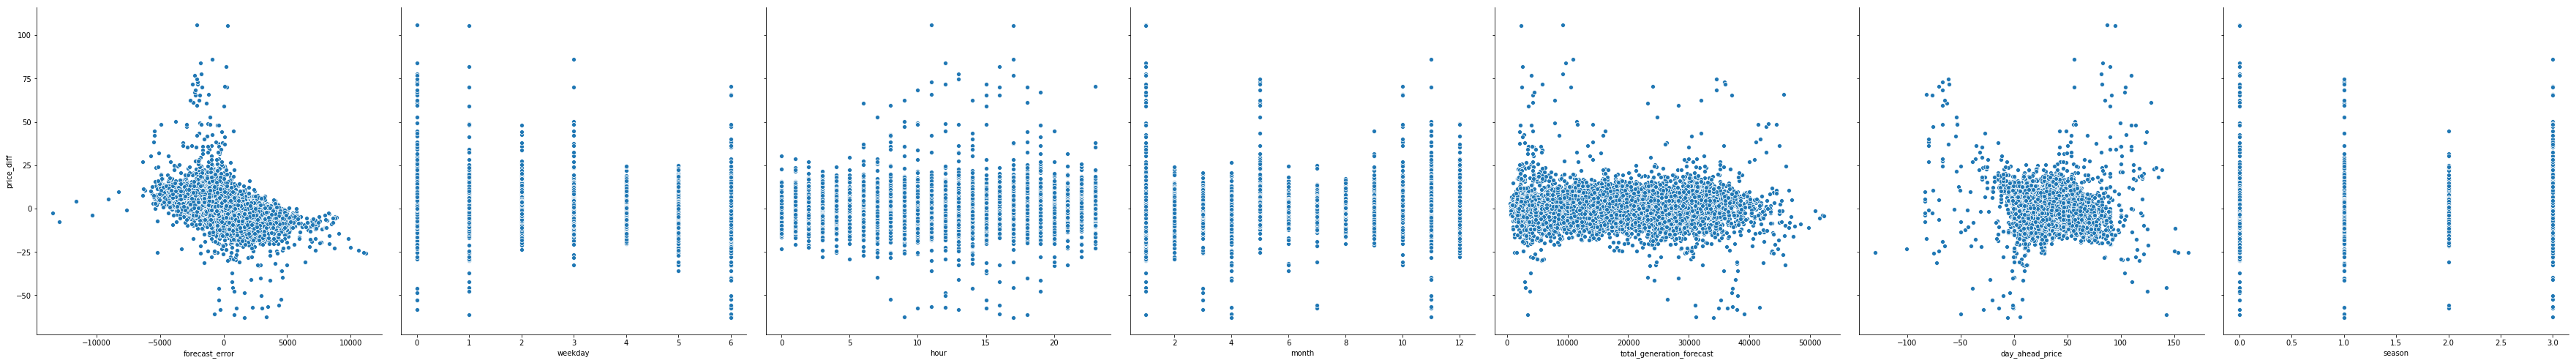

In [3]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(data, x_vars=["forecast_error", "weekday", "hour", "month", "total_generation_forecast", "day_ahead_price", "season"], y_vars=["price_diff"], height=7)

C:\Users\Tabea\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


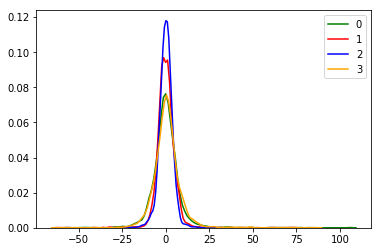

In [4]:
colors = ["g", "r", "b", "orange"]
for w in range(4):
    sns.kdeplot(data[(data.season==w)].price_diff, label=w, color=colors[w])

C:\Users\Tabea\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Tabea\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Tabea\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\Tabea\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


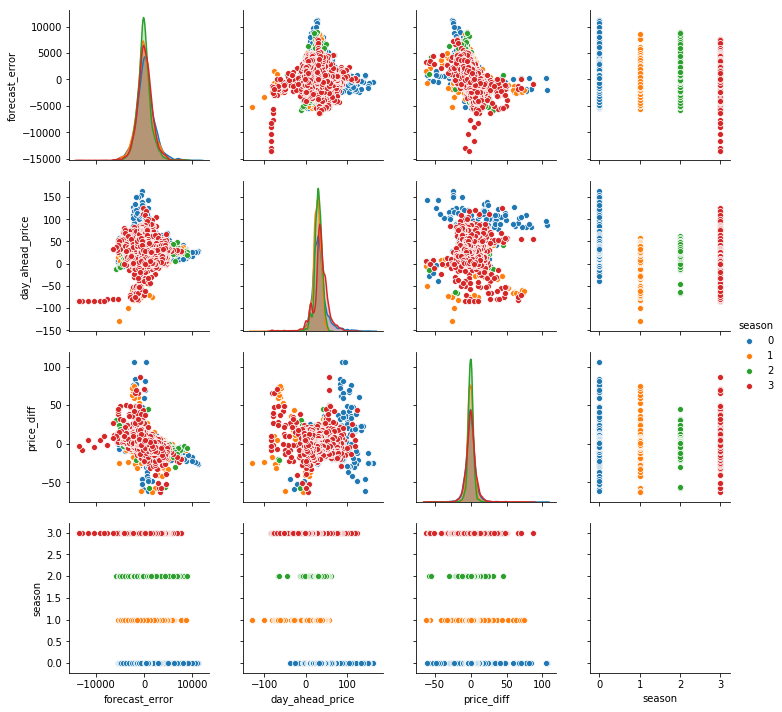

In [5]:
sns.pairplot(data[["forecast_error", "day_ahead_price", "price_diff", "season"]], hue="season")

In [102]:
def prepareData(data, mode):
    season_dummies = pd.get_dummies(data.season, prefix='season').iloc[:, :-1]
    dataWithDummies = pd.concat([data, season_dummies], axis=1)
    y = dataWithDummies["price_diff"]
    if mode==0:
        featureCols = ["forecast_error", "day_ahead_price"]+list(season_dummies)
    elif mode==1:
        featureCols = ["forecast_error", "day_ahead_price"]
    elif mode==2:
        featureCols = ["forecast_error"]+list(season_dummies)
    elif mode==3:
        featureCols = ["forecast_error"]
    X = dataWithDummies[featureCols]
    X = sm.add_constant(X)
    return X,y

def divideData(data, testSize):
    trainIndices = np.random.randint(low=0, high=len(data)-1, size=int(len(data)*testSize))
    testIndices = list(set(range(len(data))) - set(trainIndices))
    trainData = data.iloc[trainIndices,:].sort_index()
    testData = data.iloc[testIndices,:].sort_index()
    return trainData,testData

def trainModel(data, mode):
    X,y = prepareData(data, mode)
    model = sm.OLS(y, X).fit()
    #print(model.summary())
    return model
    
def predictWithModel(data, model, mode):
    X,y = prepareData(data, mode)
    pred = model.get_prediction(X)
    summary = pred.summary_frame()
    return summary["mean"]

def testRegression(data):
    testSize = 0.4
    numberOfRuns = 50
    r_sqr = list()
    mseTrain = list()
    mseTest = list()
    for m in range(4):
        print("mode:",m)
        for i in range(numberOfRuns):
            trainData, testData = divideData(data, testSize)
            model = trainModel(trainData, m)
            r_sqr.append(model.rsquared_adj)
            mseTrain.append(model.mse_resid)
            pred = predictWithModel(testData, model, m)
            mseTest.append(smem.mse(pred,testData["price_diff"]))
        print("Mean R^2 for",numberOfRuns,"runs:",sum(r_sqr)/len(r_sqr))
        print("Mean MSE training data for",numberOfRuns,"runs:",sum(mseTrain)/len(mseTrain))
        print("Mean MSE testing data for",numberOfRuns,"runs:",sum(mseTest)/len(mseTest))
        X,y = prepareData(testData, m)
        pred = model.predict(X)
        #plt.scatter(y, pred)
        #plt.ylabel("prediction")
        #plt.xlabel("Actual value")
        #plt.show()
        #sns.kdeplot(model.resid)
        #sm.qqplot(model.resid)
        #plt.show()
    
testRegression(data)

mode: 0
Mean R^2 for 50 runs: 0.20662322475240694
Mean MSE training data for 50 runs: 37.50968675101313
Mean MSE testing data for 50 runs: 36.750347581761524
mode: 1
Mean R^2 for 50 runs: 0.2076241529766914
Mean MSE training data for 50 runs: 37.17096175960772
Mean MSE testing data for 50 runs: 37.06140484795768
mode: 2
Mean R^2 for 50 runs: 0.20678162902659533
Mean MSE training data for 50 runs: 37.1623863639859
Mean MSE testing data for 50 runs: 37.163979344483636
mode: 3
Mean R^2 for 50 runs: 0.20519165278169138
Mean MSE training data for 50 runs: 37.10546135144621
Mean MSE testing data for 50 runs: 37.20360772201442


In [96]:
def getProfitForDayAhead(data):
    return data.day_ahead_price.sum(axis=0)*100

def getProfitForIntraday(data):
    return data.intraday_price.sum(axis=0)*100

def getProfitForRandom(data):
    permutation = np.random.permutation(len(data))
    ind = permutation[:int(len(permutation)/2)]
    indIntraday = permutation[int(len(permutation)/2):]
    dayAhead = data.iloc[ind,:]
    intraday = data.iloc[indIntraday,:]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))*100

def getProfitForRegression(data, model, mode):
    pred = predictWithModel(data, model, mode)
    merged = pd.concat([pred, data], axis=1)
    cols = data.columns.insert(0, "pred_price_diff")
    merged.columns = cols
    intraday = merged[merged.pred_price_diff<0]
    dayAhead = merged[merged.pred_price_diff>=0]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))*100

{'DayAhead': 41212355.0, 'Intraday': 41412752.0, 'Random': 41289244.99999999, 'Regression': 39845667.0}
savings with regression
1366688.0
1567085.0
1443577.9999999925
0.0


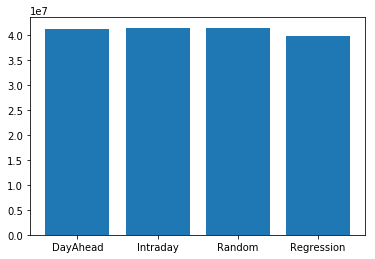

{'DayAhead': 41212355.0, 'Intraday': 41412752.0, 'Random': 41303022.0, 'Regression': 39825037.0}
savings with regression
1387318.0
1587715.0
1477985.0
0.0


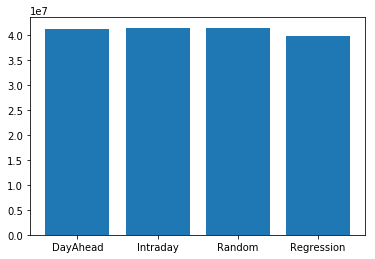

{'DayAhead': 41212355.0, 'Intraday': 41412752.0, 'Random': 41370535.0, 'Regression': 39840537.0}
savings with regression
1371818.0
1572215.0
1529998.0
0.0


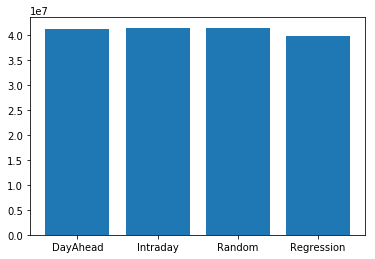

{'DayAhead': 41212355.0, 'Intraday': 41412752.0, 'Random': 41260515.0, 'Regression': 39836734.0}
savings with regression
1375621.0
1576018.0
1423781.0
0.0


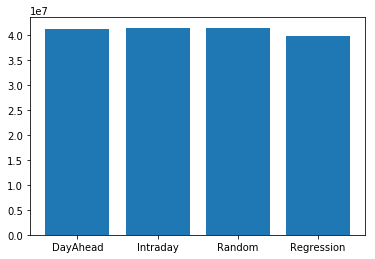

In [101]:
res = dict()
trainData, testData = divideData(data, 0.3)
for m in range(4):
    model = trainModel(trainData, m)
    res["DayAhead"] = getProfitForDayAhead(testData)
    res["Intraday"] = getProfitForIntraday(testData)
    res["Random"] = getProfitForRandom(testData)
    res["Regression"] = getProfitForRegression(testData, model, m)
    print(res)        
    print("savings with regression")
    for v in res.values():
        print(v-res["Regression"])
    plt.bar(res.keys(), res.values())
    plt.show()